In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 12 04:05:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install langdetect

In [4]:
import pandas as pd
from langdetect import detect
import re

In [5]:
df = pd.read_csv('balanced.csv') #upload csv manually!!

def clean(paragraph, words_to_remove):
    paragraph = paragraph.lower()
    paragraph = re.sub(r'\d+', '', paragraph)
    for word in words_to_remove:
        paragraph = paragraph.replace(word, "")
    paragraph = paragraph.replace(". ", ".")
    return paragraph

words_to_remove = ["[","]","-","+","verse","chorus","outro","intro",":"]

balanced_data = df.copy()
balanced_data['lyrics'] = balanced_data['lyrics'].apply(lambda x: clean(x, words_to_remove))

In [6]:
balanced_data

,valence_tags,positivity,lyrics
0,3.000000,0,.from the haunts of daily life.where is waged...
1,3.858696,0,i was waiting for a mermaid to appear.saying c...
2,7.616667,1,.i waited for you winterlong.you seem to be w...
3,6.685000,1,the world is giving you the run around.it leav...
4,3.240000,0,.you know what they say.that everything in yo...
...,...,...,...
16841,7.807083,1,if we received a warning call.would we change ...
16842,5.998475,1,.i know so many.places in the world.i follow ...
16843,3.160000,0,i bring you death.and steal your breath.i am y...
16844,2.530000,0,"close your eyes, we're coming down.close your ..."


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torchtext.vocab import vocab
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as pl
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

balanced_data = balanced_data[['lyrics', 'positivity']]  # select only the necessary columns

# Split dataset into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(balanced_data['lyrics'], balanced_data['positivity'], test_size=0.1, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load English stopwords from nltk
stopwords = set(stopwords.words('english'))

# Include punctuation in the set of characters to remove
stopwords.update(string.punctuation)

# Prepare tokenizer and vocabulary
tokenizer = get_tokenizer('basic_english')

# Tokenize (all data, train, and validation)
tokenized_data = [tokenizer(txt) for txt in balanced_data['lyrics']]  # tokenize all data
train_tokenized = [tokenizer(text) for text in train_texts] # tokenize the data (only train)
val_tokenized = [tokenizer(text) for text in val_texts] # tokenize the data (only validation)


# Filter out stopwords in the tokenization step
filtered_tokenized_data = [[token for token in tokens if token.lower() not in stopwords] for tokens in tokenized_data]
filtered_train_tokenized = [[token for token in tokens if token.lower() not in stopwords] for tokens in train_tokenized]
filtered_val_tokenized = [[token for token in tokens if token.lower() not in stopwords] for tokens in val_tokenized]


In [9]:
def build_vocab(tokenized_data):
    counter = Counter()
    for text in tokenized_data:
        counter.update(text)
    #return vocab(counter)  # This initializes the vocab
    return vocab(counter, specials=('<unk>', '<pad>'))  # This initializes the vocab

# Assuming tokenized_texts is already defined
my_vocab = build_vocab(filtered_train_tokenized)
my_vocab.set_default_index(my_vocab['<unk>'])

In [10]:
# Convert tokens to indices
train_indices = [[my_vocab[token] for token in tokens] for tokens in filtered_train_tokenized]
val_indices = [[my_vocab[token] for token in tokens] for tokens in filtered_val_tokenized]

In [11]:
#tokenized_data
# Assuming tokenized_data is a list of lists of tokens
for i, tokens in enumerate(filtered_tokenized_data):
    print(f"Sentence {i+1}: {tokens}")
    if i == 4:  # Limit the output to the first 5 sentences
        break

Sentence 1: ['haunts', 'daily', 'life', 'waged', 'daily', 'strife', 'common', 'wants', 'common', 'cares', 'cuts', 'human', 'heart', 'tears', 'rise', 'like', 'lions', 'slumber', 'in—', 'greatly', 'unknowable', 'numbers', 'let', 'tyrants', 'pour', 'around', 'apocalyptic', 'sound', 'charge', 'iron', 'wheels', 'crash', 'horses', 'heels', 'rise', 'like', 'lions', 'slumber', 'in—', 'greatly', 'unknowable', 'numbers', 'free', 'blood', 'must', 'ensue', 'many', 'workhouse', 'prison', 'pale', 'corpses', 'newly', 'risen', 'knives', 'drawn', 'let', 'see', 'standing', 'tall', 'say', 'free', 'strong', 'simple', 'words', 'set', 'wound', 'sharpened', 'swords', 'wide', 'targets', 'let', 'shade', 'cover', 'rise', 'like', 'lions', 'slumber', 'in—', 'greatly', 'unknowable', 'numbers', 'free', 'blood', 'must', 'ensue', 'many']
Sentence 2: ['waiting', 'mermaid', 'appear', 'saying', 'come', 'little', 'boy', 'drown', 'fear', 'young', 'new', 'explorers', 'spirit', 'doctor', 'livingston', 'talk', 'savage', 'sea

In [12]:
# Assuming `indices_data` is your list of lists of token indices
# And `dataset['labels']` is your list or series of labels

class LyricsDataset(torch.utils.data.Dataset):
    def __init__(self, lyrics_indices, labels):
        self.lyrics_indices = lyrics_indices  # List of lists of token indices
        self.labels = torch.tensor(labels.tolist()).float()  # Convert labels to tensor
        #self.labels = torch.tensor(labels, dtype=torch.float32)  # Convert labels to tensor

    def __len__(self):
        return len(self.lyrics_indices)

    def __getitem__(self, idx):
        lyrics_indices = torch.tensor(self.lyrics_indices[idx], dtype=torch.long)
        label = self.labels[idx]
        return lyrics_indices, label

# Initialize training and validation datasets
train_dataset = LyricsDataset(train_indices, train_labels)
val_dataset = LyricsDataset(val_indices, val_labels)

In [13]:
def collate_fn(batch):
    lyrics, labels = zip(*batch)
    lyrics = torch.nn.utils.rnn.pad_sequence(lyrics, batch_first=True, padding_value=my_vocab['<pad>'])
    labels = torch.stack(labels)
    return lyrics, labels

# DataLoader for the training set
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [14]:
# Load the GloVe embeddings
glove = GloVe(name='6B', dim=300)

# Map GloVe embeddings to your vocab
def load_pretrained_embeddings(my_vocab, glove):
    embeddings = torch.zeros(len(my_vocab), glove.dim)
    for word, idx in my_vocab.get_stoi().items():
        if word in glove.stoi:
            embeddings[idx] = glove.vectors[glove.stoi[word]]
        else:
            embeddings[idx] = torch.randn(glove.dim)  # Random init for words not in GloVe
    return embeddings

embedding_matrix = load_pretrained_embeddings(my_vocab, glove)
embedding_matrix.requires_grad = False  # Freeze the embeddings if you don't want to fine-tune them

In [15]:
embedding_matrix.shape

torch.Size([52844, 300])

In [16]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model
class BOWModel(nn.Module):
    def __init__(self, embedding_matrix):
        super(BOWModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        embedding_dim = embedding_matrix.size(1)  # Get the size of the embeddings

        # Define hidden layer sizes
        hidden_dim1 = 128  # Size of the first hidden layer
        hidden_dim2 = 64   # Size of the second hidden layer

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)  # Output layer for binary classification



    def forward(self, text):
        embedded = self.embedding(text)
        # Apply an average pooling on the sequence dimension
        pooled = embedded.mean(1)  # Assumes (batch_size, seq_length, embedding_dim)

        # Pass through the first hidden layer and apply ReLU activation
        x = F.relu(self.fc1(pooled))
        # Pass through the second hidden layer and apply ReLU activation
        x = F.relu(self.fc2(x))

        # Output layer
        output = self.fc3(x)
        return output

# Initialize model
model = BOWModel(embedding_matrix).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


Training with epochs

In [23]:
best_val_f1_acc = 0  # Initial best is set very low
best_model_state = None  # To store the best model's state

# Function to train the model
def train_model(model, train_loader, val_loader, epochs, initial_epoch=0):

    results = []  # List to store results of each epoch
    best_val_f1_acc = 0
    best_model_state = None

    for epoch in range(initial_epoch, initial_epoch + epochs):
        model.train()  # Set the model to training mode
        total_loss, total_accuracy = 0, 0
        all_predictions, all_labels = [], []
        for lyrics, labels in train_loader:
            lyrics, labels = lyrics.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(lyrics)
            loss = criterion(output.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predictions = torch.sigmoid(output).ge(0.5).float()
            total_accuracy += (predictions == labels.unsqueeze(1)).float().mean().item()
            all_predictions.extend(predictions.cpu().view(-1).tolist())
            all_labels.extend(labels.cpu().tolist())

        train_loss = total_loss / len(train_loader)
        train_accuracy = total_accuracy / len(train_loader)
        train_f1 = f1_score(all_labels, [int(p) for p in all_predictions])

        # Evaluate the model after each epoch
        val_loss, val_acc, val_f1 = evaluate(model, val_loader)

        # Save epoch results
        results.append({
            'Epoch': epoch + 1,
            'Train Loss': train_loss,
            'Train Accuracy': train_accuracy,
            'Train F1': train_f1,
            'Validation Loss': val_loss,
            'Validation Accuracy': val_acc,
            'Validation F1': val_f1
        })

        # Check if this is the best model based on Validation F1 score
        if val_f1+val_acc > best_val_f1_acc:
            best_val_f1_acc = val_f1+val_acc
            best_model_state = model.state_dict().copy()  # Copy the model state
            torch.save(best_model_state, 'best_model.pth')
            print(f"New best model saved at epoch {epoch+1} with Validation F1: {val_f1:.4f} and accuracy: {val_acc:.4f}, sum:{best_val_f1_acc:.4f}")


        # Print epoch results
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

        # Checkpoint saving
        if (epoch + 1) % 100 == 0:  # Save every 100 epochs
            torch.save(model.state_dict(), f'model_{epoch+1}_epochs.pth')
            torch.save(optimizer.state_dict(), f'optimizer_{epoch+1}_epochs.pth')
            print(f"Checkpoint saved at epoch {epoch+1}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to evaluate the model
def evaluate(model, dataloader, return_predictions=False):
    model.eval()  # Set the model to evaluation mode
    total_loss, total_accuracy = 0, 0
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for lyrics, labels in dataloader:
            lyrics, labels = lyrics.to(device), labels.to(device)
            output = model(lyrics)
            loss = criterion(output.squeeze(), labels)
            total_loss += loss.item()
            predictions = torch.sigmoid(output).ge(0.5).float()
            total_accuracy += (predictions == labels.unsqueeze(1)).float().mean().item()
            all_predictions.extend(predictions.cpu().view(-1).tolist())
            all_labels.extend(labels.cpu().tolist())

    val_loss = total_loss / len(dataloader)
    val_accuracy = total_accuracy / len(dataloader)
    val_f1 = f1_score(all_labels, [int(p) for p in all_predictions])

    if return_predictions:
        return val_loss, val_accuracy, val_f1, all_predictions, all_labels

    return val_loss, val_accuracy, val_f1


In [18]:
# Run training and evaluation
num_epochs = 100  # Define the number of epochs
results_df = train_model(model, train_loader, val_loader, num_epochs)

# Save the results to a CSV file
results_df.to_csv('training_results_stopWords.csv', index=False)
print("Results saved to 'training_results_stopWords.csv'")

Epoch 1/100 - Train Loss: 0.6929, Train Acc: 0.5203, Train F1: 0.5459, Val Loss: 0.6914, Val Acc: 0.5228, Val F1: 0.5424
Epoch 2/100 - Train Loss: 0.6900, Train Acc: 0.5293, Train F1: 0.5020, Val Loss: 0.6840, Val Acc: 0.5505, Val F1: 0.5078
Epoch 3/100 - Train Loss: 0.6870, Train Acc: 0.5397, Train F1: 0.4831, Val Loss: 0.6821, Val Acc: 0.5362, Val F1: 0.5255
Epoch 4/100 - Train Loss: 0.6860, Train Acc: 0.5380, Train F1: 0.4729, Val Loss: 0.6819, Val Acc: 0.5580, Val F1: 0.4324
Epoch 5/100 - Train Loss: 0.6840, Train Acc: 0.5441, Train F1: 0.4924, Val Loss: 0.6814, Val Acc: 0.5458, Val F1: 0.5796
Epoch 6/100 - Train Loss: 0.6827, Train Acc: 0.5475, Train F1: 0.4911, Val Loss: 0.6826, Val Acc: 0.5633, Val F1: 0.3842
Epoch 7/100 - Train Loss: 0.6814, Train Acc: 0.5544, Train F1: 0.4942, Val Loss: 0.6822, Val Acc: 0.5463, Val F1: 0.5972
Epoch 8/100 - Train Loss: 0.6804, Train Acc: 0.5553, Train F1: 0.4991, Val Loss: 0.6815, Val Acc: 0.5683, Val F1: 0.5989
Epoch 9/100 - Train Loss: 0.6786

In [24]:

# Load model and optimizer state
model.load_state_dict(torch.load('model_200_epochs.pth'))
optimizer.load_state_dict(torch.load('optimizer_200_epochs.pth'))
model.to(device)  # Make sure to reassign the model to the device

# Now train for an additional X epochs
further_train = 20
train_model(model, train_loader, val_loader, further_train, initial_epoch=240)


New best model saved at epoch 241 with Validation F1: 0.5859 and accuracy: 0.5851, sum:1.1710
Epoch 241/20 - Train Loss: 0.6025, Train Acc: 0.6339, Train F1: 0.6216, Val Loss: 1.0746, Val Acc: 0.5851, Val F1: 0.5859
New best model saved at epoch 242 with Validation F1: 0.6613 and accuracy: 0.5794, sum:1.2406
Epoch 242/20 - Train Loss: 0.5993, Train Acc: 0.6344, Train F1: 0.6274, Val Loss: 1.2967, Val Acc: 0.5794, Val F1: 0.6613
Epoch 243/20 - Train Loss: 0.5960, Train Acc: 0.6388, Train F1: 0.6333, Val Loss: 1.2086, Val Acc: 0.5739, Val F1: 0.5451
Epoch 244/20 - Train Loss: 0.6017, Train Acc: 0.6414, Train F1: 0.6333, Val Loss: 1.0630, Val Acc: 0.5853, Val F1: 0.6110
Epoch 245/20 - Train Loss: 0.5962, Train Acc: 0.6426, Train F1: 0.6379, Val Loss: 1.1492, Val Acc: 0.5763, Val F1: 0.5807
Epoch 246/20 - Train Loss: 0.5970, Train Acc: 0.6451, Train F1: 0.6389, Val Loss: 1.1973, Val Acc: 0.5675, Val F1: 0.5771
Epoch 247/20 - Train Loss: 0.5986, Train Acc: 0.6390, Train F1: 0.6363, Val Loss

,Epoch,Train Loss,Train Accuracy,Train F1,Validation Loss,Validation Accuracy,Validation F1
0,241,0.602493,0.633944,0.621574,1.074638,0.585142,0.585859
1,242,0.599311,0.634406,0.627411,1.296731,0.579363,0.661252
2,243,0.595978,0.638786,0.633313,1.208617,0.573939,0.545108
3,244,0.601738,0.641445,0.633304,1.062955,0.585259,0.611018
4,245,0.596218,0.642552,0.637900,1.149193,0.576297,0.580683
5,246,0.596997,0.645101,0.638926,1.197326,0.567453,0.577080
6,247,0.598638,0.638969,0.636273,1.132209,0.569340,0.512097
7,248,0.598492,0.638779,0.630621,1.225023,0.569929,0.468864
8,249,0.600932,0.639087,0.632998,1.169165,0.570991,0.652865
9,250,0.597433,0.646405,0.638576,1.095822,0.576297,0.538860


In [22]:
# Save the results to a CSV file
results_df.to_csv('training_results_stopWords_240epochs.csv', index=False)
print("Results saved to 'training_results_stopWords_240epochs.csv'")

Results saved to 'training_results_stopWords_240epochs.csv'


In [25]:
# Assume you're somewhere else in your code and need to load the best model
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded the best model from disk.")

Loaded the best model from disk.


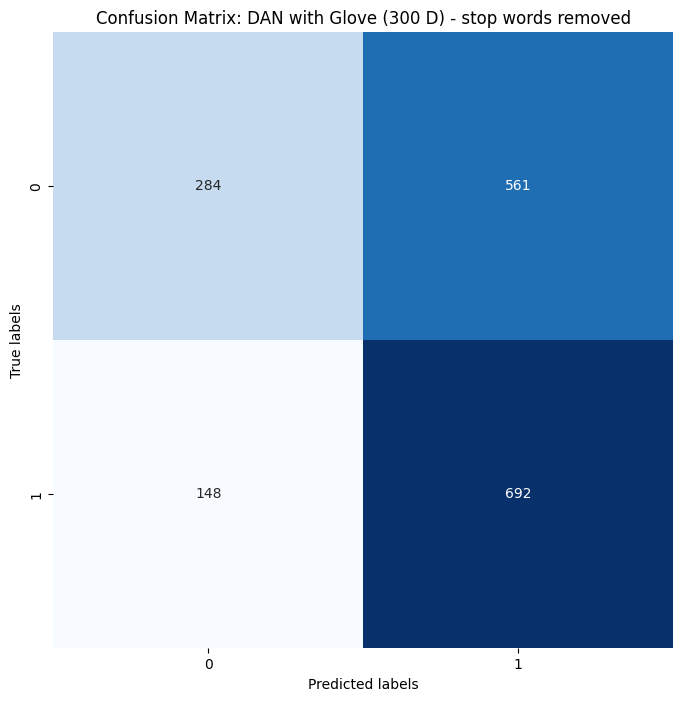

Results saved to 'training_results.csv'
Accuracy: 0.579363207772093
F1 Score: 0.6612517916865743


In [26]:
import matplotlib.pyplot as plt
# Compute the confusion matrix for the last epoch's validation data
_, val_accuracy, val_f1, predictions, labels = evaluate(model, val_loader, return_predictions=True)
cm = confusion_matrix(labels, predictions)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: DAN with Glove (300 D) - stop words removed')
plt.show()

# Save the results to a CSV file
results_df.to_csv('training_results.csv', index=False)
print("Results saved to 'training_results.csv'")

print("Accuracy:", val_accuracy)
print("F1 Score:", val_f1)